In [1]:
import time
import numpy as np
import matplotlib.pylab as plt
import emcee
from getdist import plots, MCSamples
import getdist
import scipy.stats as ss
import pandas as pd

import numpyro
import jax
import jax.numpy as jnp
import numpyro.distributions as dist
from numpyro.infer import MCMC, HMC, NUTS, init_to_value
from numpyro.handlers import seed
from numpyro.distributions import constraints
from numpyro.diagnostics import summary
from jax import grad, jit, vmap, jacfwd, jacrev
from utils.helpers import dill_save, dill_load

plt.rc("text", usetex=True)
plt.rc("font", **{"family": "sans-serif", "serif": ["Palatino"]})
figSize = (12, 8)
fontSize = 20

settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 0.3,
    "smooth_scale_1D": 0.3,
}
color1 = "#50C878"
color2 = "tomato"
color3 = "#222E50"
alpha = 0.9
palefactor = 0.9
linewidth = 2
contours = [0.68, 0.95]

In [65]:
ndim = 2
nchain = 2
tree_depth = 8
stepsize = 0.01
nsamples_nuts = 25000
nwarmup = 500

thin = 10
discard = 100
nsamples_emcee = int((nsamples_nuts * thin) / (2 * ndim) + discard)
fiducial = np.ones(ndim)
normal_prior = ss.norm(0, 1)

delta = 2.0
uniform_prior = ss.uniform(-delta, 2 * delta)

In [38]:
def rosenbrock(xvalues):
    x_i_plus_one = xvalues[1::2]
    x_i = xvalues[0::2]
    term_1 = 9.0 * (x_i_plus_one - x_i**2) ** 2
    term_2 = (x_i - 1) ** 2
    return sum(term_1 + term_2)


def loglikelihood(xvalues):
    return -rosenbrock(xvalues)


@jax.jit
def jit_loglike(xvalues):
    return loglikelihood(xvalues)


@jax.jit
def jit_grad_loglike(xvalues):
    return jax.jacfwd(loglikelihood)(xvalues)


def logposterior(xvalues):
    # logprior = sum([uniform_prior.logpdf(xvalues[i]) for i in range(ndim)])
    logprior = sum([normal_prior.logpdf(xvalues[i]) for i in range(len(xvalues))])
    if np.isfinite(logprior):
        return logprior + jit_loglike(xvalues)
    return -1e32


def calculate_summary(samples_1, samples_2, nlike, ndecimal=3):
    record = []
    for i in range(samples_1.shape[1]):
        testsamples = np.vstack(([samples_1[:, i], samples_2[:, i]]))
        summary_stats = summary(testsamples)
        summary_stats[f"p_{i}"] = summary_stats.pop("Param:0")
        record.append(summary_stats)

    record_df = []
    for i in range(len(record)):
        record_df.append(
            pd.DataFrame(record[i])
            .round(ndecimal)
            .loc[["r_hat", "n_eff", "mean", "std"]]
        )

    record_df = pd.concat(record_df, axis=1).T
    record_df["n_eff"] /= nlike
    return record_df

# $\frac{\tau[\nabla \mathcal{L}]}{\tau[\mathcal{L}]}$

In [84]:
%%timeit
jit_loglike(fiducial)

37.1 µs ± 4.51 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [85]:
%%timeit
jit_loglike(fiducial)

35.9 µs ± 1.67 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [86]:
%%timeit
jit_grad_loglike(fiducial)

42.8 µs ± 8.18 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [87]:
%%timeit
jit_grad_loglike(fiducial)

37.1 µs ± 2.75 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [88]:
dimensions = np.arange(1, 6, 1, dtype=int) * 20
nrepeat = 10

tau_like = []
tau_gradlike = []

for repeat in range(nrepeat):
    record_tau_like = []
    record_tau_grad_like = []

    for d in dimensions:
        testpoint = jnp.ones(d) + 1e-2

        start_time = time.time()
        loglike = jit_loglike(testpoint)
        time_taken = time.time() - start_time
        record_tau_like.append(time_taken)

        start_time = time.time()
        grad_loglike = jit_grad_loglike(testpoint)
        time_taken = time.time() - start_time
        record_tau_grad_like.append(time_taken)

    record_tau_like = np.asarray(record_tau_like)
    record_tau_grad_like = np.asarray(record_tau_grad_like)
    tau_like.append(record_tau_like)
    tau_gradlike.append(record_tau_grad_like)

tau_like = np.asarray(tau_like)
tau_gradlike = np.asarray(tau_gradlike)

In [89]:
time_ratio = np.mean(tau_gradlike / tau_like, axis=0)
time_ratio_error = np.std(tau_gradlike / tau_like, axis=0)

In [90]:
# dill_save(time_ratio, 'rosenbrock', 'gL_L_time_ratio')
# dill_save(time_ratio_error, 'rosenbrock', 'gL_L_time_ratio_error')

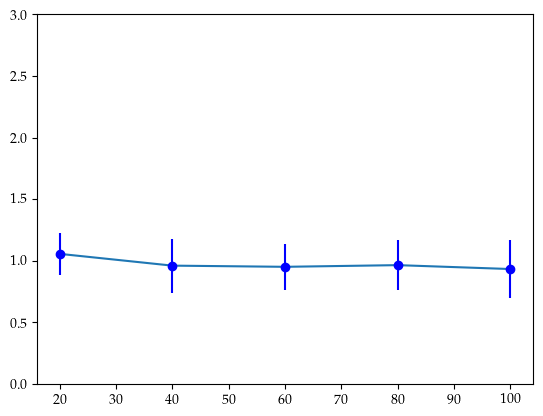

In [91]:
plt.plot(dimensions, time_ratio)
plt.errorbar(dimensions, time_ratio, yerr=time_ratio_error, fmt="bo")
plt.ylim(0, 3)
plt.show()

## EMCEE

In [39]:
def single_emcee_run(fiducial, thin=thin, ndim=ndim):
    pos = fiducial + 1e-3 * np.random.randn(2 * ndim, ndim)
    nwalkers, ndim = pos.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior)
    sampler.run_mcmc(pos, nsamples_emcee, progress=True)
    return sampler


def run_emcee(fiducial, discard=discard, thin=thin, ndim=ndim, nchain=2):
    if nchain > 1:
        record_samples = []
        total_samples = 0
        for chain in range(nchain):
            sampler = single_emcee_run(fiducial, thin, ndim)
            emcee_samples = sampler.get_chain(discard=discard, thin=thin, flat=True)
            # emcee_samples = sampler.flatchain[::thin]
            record_samples.append(emcee_samples)
            total_samples += sampler.flatchain.shape[0]
        return record_samples, total_samples

    sampler = single_emcee_run(fiducial, discard, thin, ndim)
    total_samples = sampler.flatchain.shape[0]
    emcee_samples = sampler.get_chain(discard=discard, thin=thin, flat=True)
    # emcee_samples = sampler.flatchain[::thin]
    return emcee_samples, total_samples

In [66]:
emcee_samples, nlike_emcee = run_emcee(fiducial, discard, thin, ndim, nchain=nchain)

100%|████████████████████████████████████████████████████████████████████████████| 62600/62600 [01:58<00:00, 527.38it/s]


In [67]:
calculate_summary(emcee_samples[0], emcee_samples[1], nlike_emcee)

,r_hat,n_eff,mean,std
p_0,1.0,0.105181,0.449,0.454
p_1,1.0,0.100552,0.386,0.480


## NUTS

In [42]:
def model(ndim):
    xvalues = jnp.zeros(ndim)
    for i in range(ndim):
        # y = numpyro.sample(f"x{i}", dist.Uniform(-delta, delta))
        y = numpyro.sample(f"x{i}", dist.Normal(0, 1))
        xvalues = xvalues.at[i].set(y)
    numpyro.factor("log_prob", jit_loglike(xvalues))

In [43]:
%%capture
def run_nuts(stepsize, tree_depth, nwarmup, nsamples_nuts, ndim = ndim, nchain = 2):
    init_strategy = init_to_value(
                values={f"x{i}": 1.0 for i in range(ndim)}
            )
    nuts_kernel = NUTS(model, step_size=stepsize, dense_mass=True, max_tree_depth=tree_depth, init_strategy=init_strategy)
    mcmc = MCMC(nuts_kernel, num_chains=nchain, num_warmup = nwarmup, num_samples=nsamples_nuts, chain_method='vectorized')
    mcmc.run(jax.random.PRNGKey(0), ndim=ndim, extra_fields=('potential_energy', 'num_steps', 'accept_prob'))
    nlike_nuts = mcmc.get_extra_fields()['num_steps'].sum().item()
    return mcmc, nlike_nuts

In [44]:
def process_nuts_chains(mcmc, ndim=ndim):
    chains = mcmc.get_samples(group_by_chain=True)
    record = []
    for c in range(nchain):
        samples = np.vstack([np.asarray(chains[f"x{i}"][c]) for i in range(ndim)]).T
        record.append(samples)
    return record

In [68]:
mcmc, nlike_nuts = run_nuts(stepsize, tree_depth, nwarmup, nsamples_nuts, ndim)

sample: 100%|████████████████████████████████████████████████████████████████████| 25500/25500 [01:00<00:00, 424.59it/s]


In [69]:
nuts_grouped = process_nuts_chains(mcmc, ndim)
nuts_samples = np.vstack([mcmc.get_samples()[f"x{i}"] for i in range(ndim)]).T

In [70]:
calculate_summary(nuts_grouped[0], nuts_grouped[1], nlike_nuts)

,r_hat,n_eff,mean,std
p_0,1.0,0.015727,0.445,0.453
p_1,1.0,0.033914,0.384,0.465


## Plots

In [48]:
emcee_samples_flat = np.concatenate(emcee_samples)

In [49]:
ndimplot = ndim  # 10
names = ["x%s" % i for i in range(ndimplot)]
labels = [f"$x_{i}$" for i in range(ndimplot)]
samples_emcee = MCSamples(
    samples=emcee_samples_flat[:, 0:ndimplot], names=names, labels=labels
)
samples_nuts = MCSamples(
    samples=nuts_samples[:, 0:ndimplot], names=names, labels=labels
)

Removed no burn in
Removed no burn in


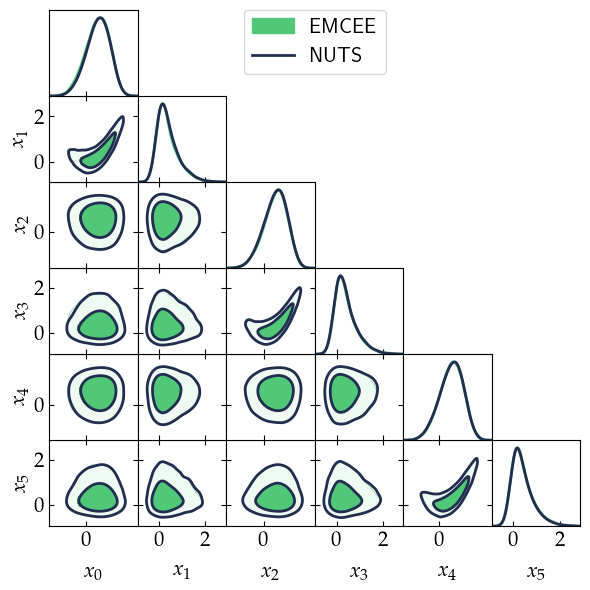

In [63]:
G = plots.getSubplotPlotter(subplot_size=1)
G.settings.solid_contour_palefactor = palefactor
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 2
G.settings.axes_fontsize = 20
G.settings.lab_fontsize = 20
G.settings.fontsize = 15  # important for padding in x-axis
G.settings.line_styles = "Accent"
G.settings.legend_fontsize = 20
G.triangle_plot(
    [samples_emcee, samples_nuts],
    filled=[True, False],
    contour_colors=[color1, color3],
    contour_lws=2,
    legend_labels=["EMCEE", "NUTS"],
)
# plt.savefig('plots/rosenbrock.pdf', bbox_inches = 'tight')
plt.show()

# Many Dimensions

In [ ]:
# testdim = np.arange(1, 11, 1) * 20

In [ ]:
# stats_emcee = {}
# nlike_emcee_record = {}
# time_emcee = {}

# for d in testdim:
#     initial = np.ones(d)

#     start_time = time.time()
#     emcee_samples, nlike_emcee = run_emcee(initial, discard, thin, d, nchain = nchain)
#     time_emcee[d] = time.time() - start_time

#     stats_emcee[d] = calculate_summary(emcee_samples[0], emcee_samples[1], nlike_emcee)
#     nlike_emcee_record[d] = nlike_emcee

In [ ]:
# dill_save(stats_emcee, 'rosenbrock', 'stats_emcee')
# dill_save(nlike_emcee_record, 'rosenbrock', 'nlike_emcee')
# dill_save(time_emcee, 'rosenbrock', 'time_emcee')

In [ ]:
# stats_nuts = {}
# nlike_nuts_record = {}
# time_nuts = {}

# for d in testdim:
#     start_time = time.time()
#     mcmc, nlike_nuts = run_nuts(stepsize, tree_depth, nwarmup, nsamples_nuts, d)
#     time_nuts[d] = time.time() - start_time

#     nuts_grouped = process_nuts_chains(mcmc, d)
#     stats_nuts[d] = calculate_summary(nuts_grouped[0], nuts_grouped[1], nlike_nuts)
#     nlike_nuts_record[d] = nlike_nuts

# dill_save(stats_nuts, 'rosenbrock', 'stats_nuts')
# dill_save(nlike_nuts_record, 'rosenbrock', 'nlike_nuts')
# dill_save(time_nuts, 'rosenbrock', 'time_nuts')

## Metrics Calculations

In [8]:
nrepeat = 15
factors = np.arange(1, 11, 1) * 10

folder_emcee = "rosenbrock/emcee_gi_"
folder_nuts = "rosenbrock/nuts_gi_"

In [9]:
record = {}
for r in range(nrepeat):
    ratios = []
    for f in factors:
        emcee_mean = dill_load(f"{folder_emcee}{r}", f"stats_emcee_{f}")[f]["n_eff"].mean()
        nuts_mean = dill_load(f"{folder_nuts}{r}", f"stats_nuts_{f}")[f]["n_eff"].mean()
        ratios.append(nuts_mean / emcee_mean)
    record[r] = ratios

In [28]:
dill_load(f"{folder_emcee}0", f"stats_emcee_{100}")

{100:       r_hat     n_eff   mean    std
 p_0   1.041  0.000069  0.441  0.323
 p_1   1.005  0.067391  0.333  0.292
 p_2   1.009  0.083852  0.472  0.280
 p_3   1.024  0.016328  0.366  0.285
 p_4   1.002  0.095942  0.429  0.331
 ...     ...       ...    ...    ...
 p_95  1.001  0.062743  0.380  0.291
 p_96  1.001  0.066959  0.459  0.261
 p_97  1.001  0.073575  0.355  0.298
 p_98  1.003  0.081436  0.445  0.310
 p_99  1.002  0.091873  0.363  0.299
 
 [100 rows x 4 columns]}

In [29]:
dill_load(f"{folder_nuts}0", f"stats_nuts_{100}")

{100:       r_hat     n_eff   mean    std
 p_0     1.0  0.009021  0.446  0.450
 p_1     1.0  0.012980  0.381  0.469
 p_2     1.0  0.010458  0.445  0.450
 p_3     1.0  0.013441  0.379  0.469
 p_4     1.0  0.009833  0.453  0.455
 ...     ...       ...    ...    ...
 p_95    1.0  0.013008  0.383  0.474
 p_96    1.0  0.009034  0.453  0.453
 p_97    1.0  0.013137  0.388  0.479
 p_98    1.0  0.009792  0.447  0.453
 p_99    1.0  0.013119  0.383  0.469
 
 [100 rows x 4 columns]}

In [10]:
df = pd.DataFrame(record).T

In [30]:
df

,0,1,2,3,4,5,6,7,8,9
0,0.304781,0.239006,0.229211,0.214002,0.209930,0.226453,0.203977,0.198348,0.161610,0.150902
1,0.258499,0.224842,0.198442,0.204742,0.216602,0.233882,0.218812,0.182083,0.154549,0.162727
2,0.230256,0.230376,0.220111,0.215826,0.203221,0.217664,0.204167,0.164696,0.176866,0.165491
3,0.240201,0.210547,0.206127,0.215684,0.233478,0.218703,0.186536,0.183568,0.194112,0.156007
4,0.290465,0.234230,0.208160,0.198736,0.229652,0.226160,0.208817,0.186123,0.162932,0.138039
5,0.243615,0.217094,0.200850,0.200461,0.216536,0.202613,0.224846,0.189835,0.171447,0.155455
6,0.259978,0.233106,0.214485,0.213833,0.227773,0.210932,0.210039,0.158219,0.177002,0.145947
7,0.272045,0.208911,0.220516,0.211844,0.193906,0.206418,0.220120,0.199683,0.184227,0.155366
8,0.251049,0.198022,0.241892,0.196464,0.215049,0.217389,0.210286,0.206354,0.172369,0.140619
9,0.249534,0.278515,0.197574,0.206809,0.214560,0.203394,0.217224,0.196224,0.177539,0.149236


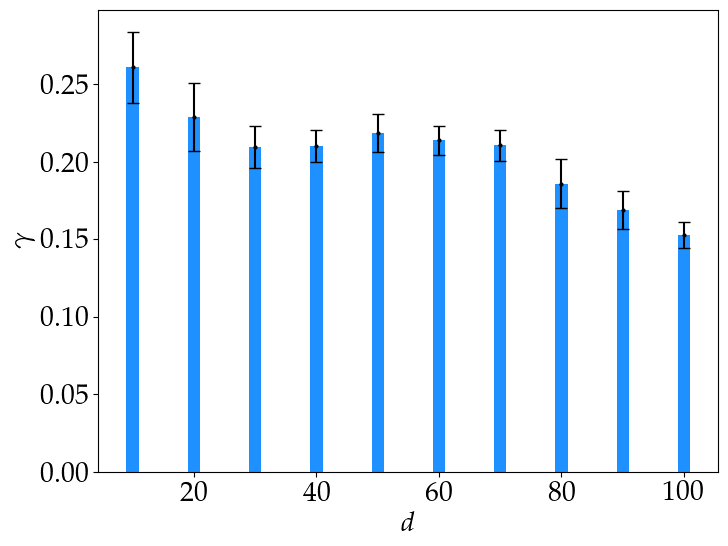

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(factors, df.mean(0), color="dodgerblue", width=2.0)
ax.errorbar(factors, df.mean(0), yerr=df.std(0), fmt="o", color="k", markersize=2, capsize=4)
# ax.axhline(1, linestyle="--")
ax.set_ylabel(r"$\gamma$", fontsize=fontSize)
ax.set_xlabel(r"$d$", fontsize=fontSize)
ax.tick_params(axis="x", labelsize=fontSize)
ax.tick_params(axis="y", labelsize=fontSize)
# plt.ylim(0, 6)
# plt.savefig('plots/rosenbrock_different_d.pdf', bbox_inches = 'tight')
plt.show()

# Another Metric

$$
q = \dfrac{\tilde{N}_{eff}}{Td}
$$

where $\tilde{N}_{eff} \equiv \dfrac{N_{eff}}{N_{like}}$, $T$ is the total time taken to sample the posterior and $d$ is some distance measure from a reference point (ideally the MAP). In this case, we calculate $d$ as follows:

$$
d = \dfrac{\mu_{*}-\mu_{ref}}{\sqrt{\sigma_{*}^{2} + \sigma_{ref}^{2}}}
$$

Then the first equation takes into account, 
1) how efficient the samples are
2) how many likelihood evaluations did we do
3) how long did it take to sample them
4) how close they are from the "true" underlying distribution
   
We also define 

$$
\eta = \dfrac{q_{NUTS}}{q_{EMCEE}}
$$

### Rosenbrock in 6D with EMCEE
<p align="center" >
    <img width="25%" src="plots/Rosenbrock-EMCEE.png">
</p>

### Rosenbrock in 6D with NUTS
<p align="center" >
    <img width="25%" src="plots/Rosenbrock-NUTS.png">
</p>


In [16]:
def compute_distance(results):
    dimensions = results.shape[0]
    # this is the mean and standard deviation for a 2D Rosenbrock
    # appears to be repeated over many dimensions
    reference = pd.DataFrame(
        [[0.45, 0.45], [0.39, 0.48]] * int(dimensions / 2), columns=["mean", "std"]
    )
    reference.index = [f"p_{i}" for i in range(dimensions)]
    difference = np.abs(results["mean"] - reference["mean"])
    std2_sum = results["std"] ** 2 + reference["std"] ** 2
    return np.mean(difference / np.sqrt(std2_sum))

In [17]:
dims = np.arange(1, 11, 1) * 10

In [18]:
q_record = []
gr_record = []

t_record_nuts = []
t_record_emcee = []
d_record_nuts = []
d_record_emcee = []
gr_record_nuts = []
gr_record_emcee = []

for r in range(15):
    d_emcee = np.zeros_like(dims, dtype=np.float32)
    d_nuts = np.zeros_like(dims, dtype=np.float32)

    n_emcee = np.zeros_like(dims, dtype=np.float32)
    n_nuts = np.zeros_like(dims, dtype=np.float32)

    t_emcee = np.zeros_like(dims, dtype=np.float32)
    t_nuts = np.zeros_like(dims, dtype=np.float32)

    gr_emcee = np.zeros_like(dims, dtype=np.float32)
    gr_nuts = np.zeros_like(dims, dtype=np.float32)

    for i, d in enumerate(dims):
        stats_emcee = dill_load(f"{folder_emcee}{r}", f"stats_emcee_{d}")[d]
        stats_nuts = dill_load(f"{folder_nuts}{r}", f"stats_nuts_{d}")[d]

        d_emcee[i] = compute_distance(stats_emcee)
        d_nuts[i] = compute_distance(stats_nuts)

        n_emcee[i] = stats_emcee["n_eff"].mean()
        n_nuts[i] = stats_nuts["n_eff"].mean()

        t_emcee[i] = dill_load(f"{folder_emcee}{r}", f"time_emcee_{d}")[d] / 60
        t_nuts[i] = dill_load(f"{folder_nuts}{r}", f"time_nuts_{d}")[d] / 60

        gr_emcee[i] = stats_emcee["r_hat"].mean()
        gr_nuts[i] = stats_nuts["r_hat"].mean()

    q_emcee = n_emcee / (t_emcee * d_emcee)
    q_nuts = n_nuts / (t_nuts * d_nuts)
    q_ratio = q_nuts / q_emcee
    q_record.append(q_ratio)

    # quantities for each sampler
    d_record_nuts.append(d_nuts)
    d_record_emcee.append(d_emcee)

    t_record_nuts.append(t_nuts)
    t_record_emcee.append(t_emcee)

    gr_record_nuts.append(gr_nuts)
    gr_record_emcee.append(gr_emcee)

In [19]:
df_q = pd.DataFrame(q_record)
df_gr = pd.DataFrame(gr_record)

df_t_nuts = pd.DataFrame(t_record_nuts)
df_t_emcee = pd.DataFrame(t_record_emcee)

df_d_nuts = pd.DataFrame(d_record_nuts)
df_d_emcee = pd.DataFrame(d_record_emcee)

df_gr_nuts = pd.DataFrame(gr_record_nuts)
df_gr_emcee = pd.DataFrame(gr_record_emcee)

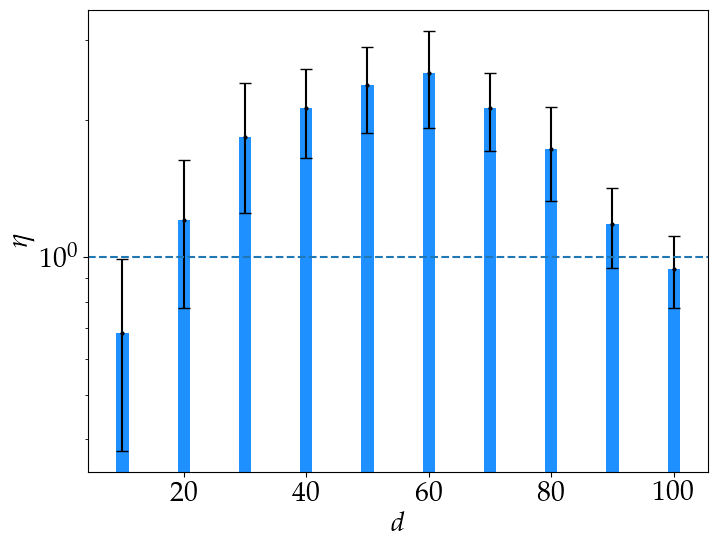

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(factors, df_q.mean(0), color="dodgerblue", width=2.0)
ax.errorbar(factors, df_q.mean(0), yerr=df_q.std(0), fmt="o", color="k", markersize=2, capsize=4)
ax.axhline(1, linestyle="--")
ax.set_ylabel(r"$\eta$", fontsize=fontSize)
ax.set_xlabel(r"$d$", fontsize=fontSize)
ax.tick_params(axis="x", labelsize=fontSize)
ax.tick_params(axis="y", labelsize=fontSize)
ax.set_yscale("log")
# plt.savefig('plots/rosenbrock_different_d.pdf', bbox_inches = 'tight')
plt.show()

In [21]:
index = np.arange(len(dims))
bar_width = 0.20

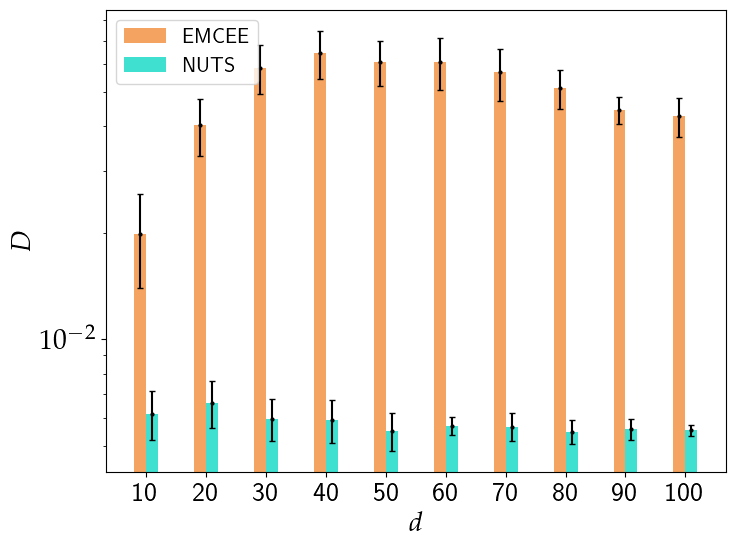

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(index, df_d_emcee.mean(0), bar_width, label="EMCEE", color="sandybrown")
ax.bar(index + bar_width, df_d_nuts.mean(0), bar_width, label="NUTS", color="turquoise")
ax.errorbar(index, df_d_emcee.mean(0),yerr=df_d_emcee.std(0), fmt="o", color="k", markersize=2, capsize=2)
ax.errorbar(index + bar_width, df_d_nuts.mean(0), yerr=df_d_nuts.std(0), fmt="o", color="k", markersize=2, capsize=2)
ax.set_xlabel("$d$", fontsize=fontSize)
ax.set_ylabel(r"$D$", fontsize=fontSize)
# ax.set_title('KL Divergence', fontsize = fontSize)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(dims)
ax.set_yscale("log")
ax.legend(loc="upper left", prop={"family": "sans-serif", "size": 15})
plt.tick_params(axis="x", labelsize=fontSize)
plt.tick_params(axis="y", labelsize=fontSize)
# plt.savefig('plots/rosenbrock_distance_nuts_emcee.pdf', bbox_inches = 'tight')
plt.show()

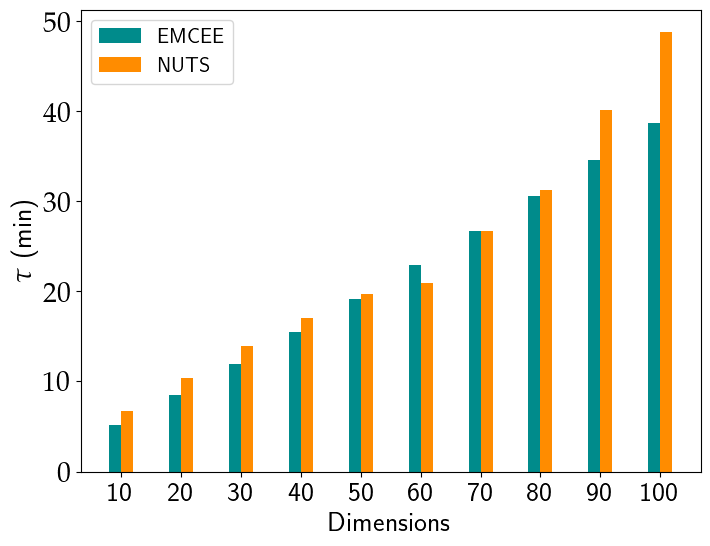

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(index, df_t_emcee.mean(0), bar_width, label="EMCEE", color="darkcyan")
ax.bar(
    index + bar_width, df_t_nuts.mean(0), bar_width, label="NUTS", color="darkorange"
)
# ax.errorbar(index, df_t_emcee.mean(0), yerr=df_t_emcee.std(0), fmt="o", color="k", markersize = 2, capsize = 2)
# ax.errorbar(index+bar_width, df_t_nuts.mean(0), yerr=df_t_nuts.std(0), fmt="o", color="k", markersize = 2, capsize = 2)
ax.set_xlabel("Dimensions", fontsize=fontSize)
ax.set_ylabel(r"$\tau$ (min)", fontsize=fontSize)
# ax.set_title('KL Divergence', fontsize = fontSize)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(dims)
# ax.set_yscale('log')
ax.legend(loc="upper left", prop={"family": "sans-serif", "size": 15})
plt.tick_params(axis="x", labelsize=fontSize)
plt.tick_params(axis="y", labelsize=fontSize)
# plt.savefig('rosenbrock/time.pdf', bbox_inches = 'tight')
plt.show()

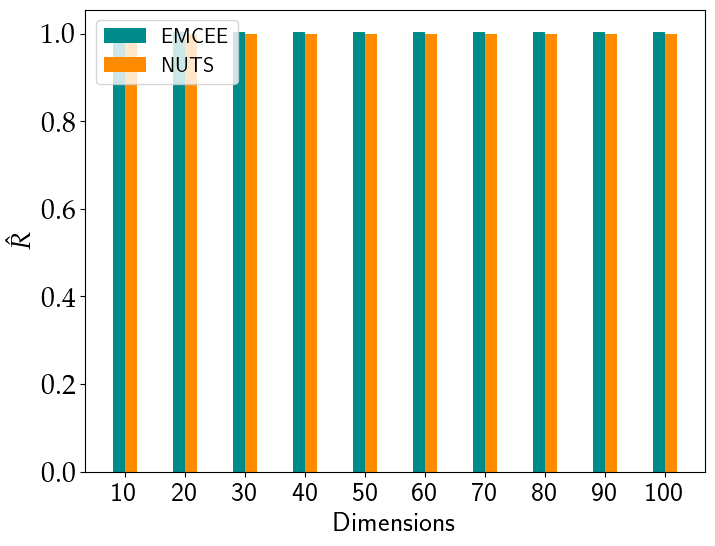

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(index, df_gr_emcee.mean(0), bar_width, label="EMCEE", color="darkcyan")
ax.bar(
    index + bar_width, df_gr_nuts.mean(0), bar_width, label="NUTS", color="darkorange"
)
# ax.errorbar(index, df_t_emcee.mean(0), yerr=df_t_emcee.std(0), fmt="o", color="k", markersize = 2, capsize = 2)
# ax.errorbar(index+bar_width, df_t_nuts.mean(0), yerr=df_t_nuts.std(0), fmt="o", color="k", markersize = 2, capsize = 2)
ax.set_xlabel("Dimensions", fontsize=fontSize)
ax.set_ylabel(r"$\hat{R}$", fontsize=fontSize)
# ax.set_title('KL Divergence', fontsize = fontSize)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(dims)
# ax.set_yscale('log')
ax.legend(loc="upper left", prop={"family": "sans-serif", "size": 15})
plt.tick_params(axis="x", labelsize=fontSize)
plt.tick_params(axis="y", labelsize=fontSize)
# plt.savefig('rosenbrock/gelman_rubin_statistics.pdf', bbox_inches = 'tight')
plt.show()

# Rosenbrock Posterior in $d=100$

In [23]:
emcee_mcmc = dill_load("rosenbrock/emcee_samples", "dimension_good_initial_100")

In [24]:
emcee_samples = np.vstack(emcee_mcmc)

In [25]:
nuts_mcmc = dill_load("rosenbrock/nuts_samples", "dimension_good_initial_100")

In [26]:
def process_nuts_chains(mcmc, ndim, nchain):
    chains = mcmc.get_samples(group_by_chain=True)
    record = []
    for c in range(nchain):
        samples = np.vstack([np.asarray(chains[f"x{i}"][c]) for i in range(ndim)]).T
        record.append(samples)
    return record

In [27]:
nuts_samples = process_nuts_chains(nuts_mcmc, ndim=100, nchain=2)

In [28]:
nuts_samples_all = np.vstack(nuts_samples)

In [29]:
ndimplot = 6
names = ["x%s" % i for i in range(ndimplot)]
labels = [f"$x_{i}$" for i in range(ndimplot)]
samples_emcee = MCSamples(
    samples=emcee_samples[:, -ndimplot:], names=names, labels=labels
)
samples_nuts = MCSamples(
    samples=nuts_samples_all[:, -ndimplot:], names=names, labels=labels
)

Removed no burn in
Removed no burn in


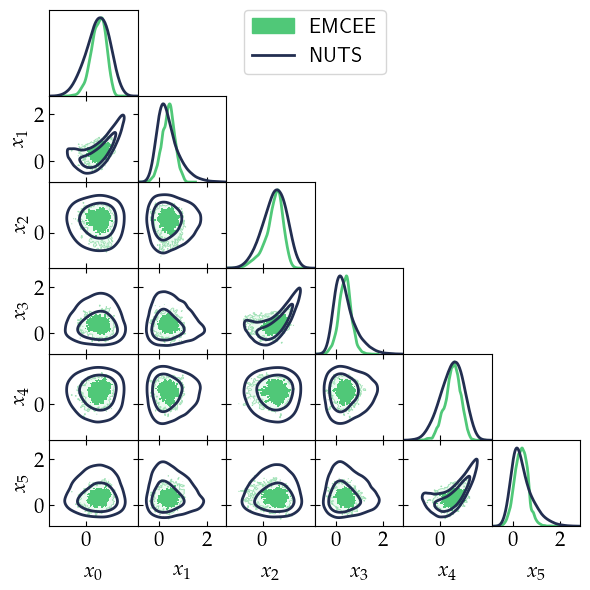

In [30]:
G = plots.getSubplotPlotter(subplot_size=1)
G.settings.solid_contour_palefactor = palefactor
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 2
G.settings.axes_fontsize = 20
G.settings.lab_fontsize = 20
G.settings.fontsize = 15  # important for padding in x-axis
G.settings.line_styles = "Accent"
G.settings.legend_fontsize = 20
G.triangle_plot(
    [samples_emcee, samples_nuts],
    filled=[True, False],
    contour_colors=[color1, color3],
    contour_lws=2,
    legend_labels=["EMCEE", "NUTS"],
)
# plt.savefig('plots/rosenbrock.pdf', bbox_inches = 'tight')
plt.show()

In [37]:
testing = df * (df_d_emcee / df_d_nuts)

In [38]:
testing.mean(0)

0    0.881977
1    1.445235
2    2.130703
3    2.335121
4    2.453570
5    2.302448
6    2.134046
7    1.759113
8    1.362318
9    1.185998
dtype: float64